In [16]:
import scvelo as scv
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

from velovi import preprocess_data
from rgv_tools.preprocessing import filter_genes, set_prior_grn

In [24]:
adata = sc.read_h5ad("/lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/10x_shallow_NCC/NCC_velocity.h5ad")
scv.pp.filter_genes(adata, min_shared_counts=20)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=3000)
scv.pp.log1p(adata)

#sc.tl.pca(adata)
sc.pp.neighbors(adata,n_pcs = 30,n_neighbors = 50)
sc.tl.umap(adata)
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Filtered out 22217 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 3000 highly variable genes.


/tmp/ipykernel_425766/2758118656.py:5: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata)


computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


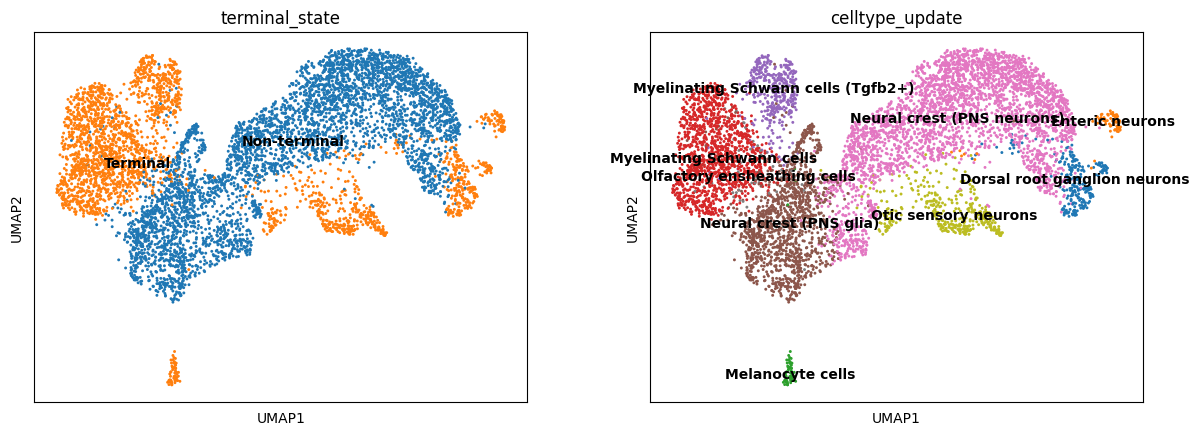

In [25]:
sc.pl.umap(
    adata,
    color=["terminal_state","celltype_update"],
    # Setting a smaller point size to get prevent overlap
    legend_loc = "on data"
)

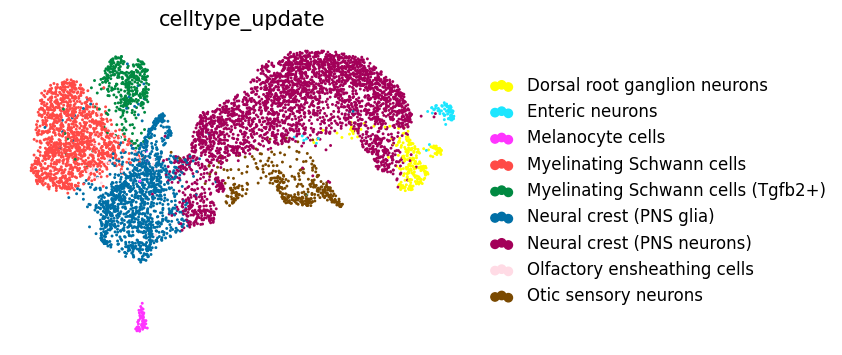

In [29]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    sc.pl.umap(adata,color = "celltype_update",ax = ax,palette=sc.pl.palettes.godsnot_102, frameon=False)

    fig.savefig("/lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/10x_shallow_NCC/INTRO_plot.svg", format="svg", transparent=True, bbox_inches="tight")

In [13]:
GRN = pd.read_parquet("/lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/10x_shallow_NCC/regulon_mat_processed_all_regulons.parquet")
    
adata = set_prior_grn(adata, GRN.T)
velocity_genes = preprocess_data(adata.copy()).var_names.tolist()
TF = adata.var_names[adata.uns["skeleton"].sum(1) != 0]
var_mask = np.union1d(TF, velocity_genes)

adata = adata[:, var_mask].copy()
adata = filter_genes(adata)
adata = preprocess_data(adata, filter_on_r2=False)

adata.var["velocity_genes"] = adata.var_names.isin(velocity_genes)
adata.var["TF"] = adata.var_names.isin(TF)

print(adata)
adata.write_h5ad("/lustre/groups/ml01/workspace/weixu.wang/regvelo_revision/10x_shallow_NCC/adata_processed_velo.h5ad")

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Number of genes: 1187
Number of genes: 1164
AnnData object with n_obs × n_vars = 6788 × 1164
    obs: 'nCount_RNA', 'nFeature_RNA', 'cell_id', 'UMI_count', 'gene_count', 'major_trajectory', 'celltype_update', 'UMAP_1', 'UMAP_2', 'UMAP_3', 'UMAP_2d_1', 'UMAP_2d_2', 'terminal_state', 'nCount_intron', 'nFeature_intron', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'vf_vst_counts_mean', 'vf_vst_counts_variance', 'vf_vst_counts_variance.expected', 'vf_vst_counts_variance.standardized', 'vf_vst_counts_variable', 'vf_vst_counts_rank', 'var.features', 'var.features.rank', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_genes', 'TF'
    uns: 'log1p', 'neighbors', 'umap', 'terminal_state_colors', 'celltype_update_colors', 'regulators', 'targets', 'skeleton', 'network'
    obsm: 'X_pca',